# Climate risk to rice labour
Rice is an important part of the global food supply. It provides half
of calories consumed in Asia. Frequently, rice is harvested by hand.
This can be strenuous work, often in hot and humid conditions. Hot and
humid conditions are projected to become more common due to global
warming.

In this notebook, a global climate model is combined with crop
calendars in order to identify locations in which workers engaged in
rice harvest may already be affected by hot and humid weather, and the
extent to which this will increase with global warming.

This is intended as an illustration of a more complete analysis, which
you can follow and reproduce on your own computer.
For this reason, we use only one climate model, and only one future
pathway for emissions.

In [1]:
# Imports

import warnings
import xarray as xr
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import matplotlib as mpl
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from psychrolib import GetTWetBulbFromHumRatio, SI, SetUnitSystem

from src.dayofyear import dayofyear_checker
from src.Labour import labour_sahu

absolute_zero = -273.15
SetUnitSystem(SI)

# Silence warning about dividing by 0 or nan.
np.seterr(divide="ignore", invalid="ignore")
warnings.filterwarnings("once", ".*No gridpoint belongs to any region.*")
warnings.filterwarnings("once", ".*Geometry is in a geographic CRS.*")
warnings.filterwarnings("once", ".*invalid value .*")
warnings.filterwarnings("once", ".*All-NaN slice.*")
warnings.filterwarnings("once", ".*invalid value encountered in.*")

## RiceAtlas

"...a spatial database on the seasonal distribution of the world’s rice
production. It consists of data on rice planting and harvesting dates by
growing season and estimates of monthly production for all rice-producing
countries. Sources used for planting and harvesting dates include global and
regional databases, national publications, online reports, and expert
knowledge."

[Laborte, A. G. et al., 2017](https://www.nature.com/articles/sdata201774)

Details of loading the RiceAtlas data are handled by [../src/RiceAtlas.py](../src/RiceAtlas.py)

In [2]:
from src.RiceAtlas import ra

ra

,OBJECTID,ISO,COUNTRY,REGION,SUB_REGION,HASC,Shape_Leng,Shape_Le_1,Shape_Area,NAME1,...,A_Q1,A_Q2,A_Q3,A_Q4,P_Q1,P_Q2,P_Q3,P_Q4,CONTINENT,geometry
0,1,BRN,Brunei,Belait,Belait,BN.BE,2.614166,2.614166,0.231650,Main,...,1862.0,0.0,0.0,0.0,1119.0,0.0,0.0,0.0,Asia,"POLYGON ((114.52955 4.71594, 114.52980 4.71531..."
1,2,BTN,Bhutan,Bumthang,Bumthang,BT.BU,2.650571,2.650571,0.254616,Main,...,0.0,0.0,0.0,15.0,0.0,0.0,0.0,94.0,Asia,"POLYGON ((90.70934 28.08933, 90.71093 28.08835..."
2,3,BTN,Bhutan,Chhukha,Chhukha,BT.CK,2.462051,2.462051,0.159026,Main,...,0.0,0.0,0.0,1130.0,0.0,0.0,0.0,3196.0,Asia,"POLYGON ((89.58981 27.24489, 89.59187 27.24487..."
3,4,BTN,Bhutan,Chirang,Chirang,BT.CR,1.360309,1.360309,0.056008,Main,...,0.0,0.0,0.0,1669.0,0.0,0.0,0.0,3844.0,Asia,"POLYGON ((90.15416 27.15287, 90.15668 27.15251..."
4,5,BTN,Bhutan,Daga,Daga,BT.DA,1.844243,1.844243,0.121813,Main,...,0.0,0.0,0.0,2377.0,0.0,0.0,0.0,6306.0,Asia,"POLYGON ((89.79521 27.26359, 89.79643 27.26202..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2132,1556,IND,India,Maharashtra,Aurangabad,IN.MH.AU,8.388770,8.388770,0.577789,Kharif,...,0.0,0.0,0.0,589.0,0.0,0.0,0.0,316.0,Asia,"MULTIPOLYGON (((74.82336 20.24531, 74.82691 20..."
2133,1557,IND,India,Maharashtra,Jalna,IN.MH.JN,5.480544,5.480544,0.474685,Kharif,...,0.0,0.0,0.0,688.0,0.0,0.0,0.0,474.0,Asia,"POLYGON ((76.02627 20.64548, 76.03284 20.64016..."
2134,1558,IND,India,Madhya Pradesh,Indore,IN.MP.IN,1.324605,1.324605,0.066867,Kharif,...,0.0,0.0,0.0,10.0,0.0,0.0,0.0,17.0,Asia,"POLYGON ((75.69350 22.81288, 75.69353 22.81413..."
2135,1559,IND,India,Madhya Pradesh,Neemuch,IN.MP.NE,4.154339,4.154339,0.134925,Kharif,...,0.0,0.0,0.0,21.0,0.0,0.0,0.0,44.0,Asia,"POLYGON ((74.75378 24.57838, 74.75154 24.58611..."


In [3]:
# Reduce scope of RiceAtlas data
ra = ra[ra.CONTINENT == "Asia"]

RiceAtlas has one row per location. The locations have geometries
provided. Some are much larger that others.

Within each row, there is information for multiple cropping seasons.
For example, the columns 'P_S1', 'P_S2', and 'P_S3', give production
in the first, second and third cropping season.
The number of columns does not change between rows, and there are
always entries for 3 cropping seasons. If there are not 3 croppping
seasons in a location, then the production will be 0 for that season.

In [4]:
ra[["COUNTRY", "REGION", "SUB_REGION", "P_S1", "P_S2", "P_S3"]].sample(10)

,COUNTRY,REGION,SUB_REGION,P_S1,P_S2,P_S3
46,Laos,Louang Namtha,Louang Namtha,57575.0,5759.0,0.0
866,Nepal,Dhawalagiri,Baglung,122731.0,0.0,0.0
1768,India,Jammu and Kashmir,Srinagar,53634.0,0.0,0.0
1684,India,Chhattisgarh,Dhamtari,345224.0,0.0,115512.0
1645,India,Bihar,Aurangabad,0.0,572978.0,0.0
392,Thailand,North,Lampang,246329.0,23930.0,0.0
1975,India,Uttar Pradesh,Ambedkar Nagar,476209.0,0.0,0.0
364,Malaysia,Negeri Sembilan,Negeri Sembilan,5573.0,2994.0,0.0
2118,India,Maharashtra,Nandurbar,27960.0,0.0,0.0
1707,India,Gujarat,Narmada,19983.0,0.0,0.0


## CMIP6
Using the latest generation of climate models, we look for trends in
local changes in WBGT against global climate change.

In this example, we only use one model.

* 'tas' = mean near-surface air temperature (Kelvin)
* 'tasmax' = max near-surface air temperature (Kelvin)
* 'huss' = humidity ratio (dimensionless)
* 'ps' = near-surface pressure (Pa)


See references re. CMIP6:
* [Eyring, V. et al., 2016](https://doi.org/10.5194/gmd-9-1937-2016)
* [O’Neill, B. C. et al., 2016](https://doi.org/10.5194/gmd-9-3461-2016)

Use openDAP to access directly from ESGF.
This requires you to supply an ESGF login.
See [ESGF User Guide](https://esgf.github.io/esgf-user-support/user_guide.html)

In [6]:
from src.esgf_opendap import get_openDAP_urls

CMIP6_variables = ["tas", "tasmax", "huss", "ps"]
CMIP6_experiments = ["historical", "ssp245"]
CMIP6_search = {
    "project": "CMIP6",
    "source_id": "UKESM1-0-LL",
    "experiment_id": "historical",
    "variable": "tas",
    "frequency": "mon",
    "variant_label": "r1i1p1f2",
    "data_node": "esgf-data3.ceda.ac.uk",
}

openDAP_urls =[] 
for experiment in CMIP6_experiments:
    CMIP6_search["experiment_id"] = experiment
    for var in CMIP6_variables:
        CMIP6_search["variable"] = var
        openDAP_urls.append( get_openDAP_urls(CMIP6_search))

print(openDAP_urls)

[['http://esgf-data3.ceda.ac.uk/thredds/dodsC/esg_cmip6/CMIP6/CMIP/MOHC/UKESM1-0-LL/historical/r1i1p1f2/Amon/tas/gn/v20190406/tas_Amon_UKESM1-0-LL_historical_r1i1p1f2_gn_185001-194912.nc', 'http://esgf-data3.ceda.ac.uk/thredds/dodsC/esg_cmip6/CMIP6/CMIP/MOHC/UKESM1-0-LL/historical/r1i1p1f2/Amon/tas/gn/v20190406/tas_Amon_UKESM1-0-LL_historical_r1i1p1f2_gn_195001-201412.nc'], ['http://esgf-data3.ceda.ac.uk/thredds/dodsC/esg_cmip6/CMIP6/CMIP/MOHC/UKESM1-0-LL/historical/r1i1p1f2/Amon/tasmax/gn/v20190627/tasmax_Amon_UKESM1-0-LL_historical_r1i1p1f2_gn_185001-194912.nc', 'http://esgf-data3.ceda.ac.uk/thredds/dodsC/esg_cmip6/CMIP6/CMIP/MOHC/UKESM1-0-LL/historical/r1i1p1f2/Amon/tasmax/gn/v20190627/tasmax_Amon_UKESM1-0-LL_historical_r1i1p1f2_gn_195001-201412.nc'], ['http://esgf-data3.ceda.ac.uk/thredds/dodsC/esg_cmip6/CMIP6/CMIP/MOHC/UKESM1-0-LL/historical/r1i1p1f2/Amon/huss/gn/v20190406/huss_Amon_UKESM1-0-LL_historical_r1i1p1f2_gn_185001-194912.nc', 'http://esgf-data3.ceda.ac.uk/thredds/dodsC/e

In [7]:
# Open using xarray as openDAP.
# If this fails, you might try changing the data_node in the query.
ds = xr.open_mfdataset(
    openDAP_urls, join="exact", combine="by_coords", use_cftime=True
)
ds = ds.drop('height')
ds

<xarray.Dataset>
Dimensions:    (bnds: 2, lat: 144, lon: 192, time: 3012)
Coordinates:
  * time       (time) object 1850-01-16 00:00:00 ... 2100-12-16 00:00:00
  * lat        (lat) float64 -89.38 -88.12 -86.88 -85.62 ... 86.88 88.12 89.38
  * lon        (lon) float64 0.9375 2.812 4.688 6.562 ... 355.3 357.2 359.1
Dimensions without coordinates: bnds
Data variables:
    time_bnds  (time, bnds) object dask.array<chunksize=(1200, 2), meta=np.ndarray>
    lat_bnds   (time, lat, bnds) float64 dask.array<chunksize=(1200, 144, 2), meta=np.ndarray>
    lon_bnds   (time, lon, bnds) float64 dask.array<chunksize=(1200, 192, 2), meta=np.ndarray>
    huss       (time, lat, lon) float32 dask.array<chunksize=(1200, 144, 192), meta=np.ndarray>
    ps         (time, lat, lon) float32 dask.array<chunksize=(1200, 144, 192), meta=np.ndarray>
    tas        (time, lat, lon) float32 dask.array<chunksize=(1200, 144, 192), meta=np.ndarray>
    tasmax     (time, lat, lon) float32 dask.array<chunksize=(1200, 144, 192), meta=np.ndarray>
Attributes:
    Conventions:                     CF-1.7 CMIP-6.2
    activity_id:                     CMIP
    branch_method:                   standard
    branch_time_in_child:            0.0
    branch_time_in_parent:           144000.0
    creation_date:                   2019-04-05T16:02:56Z
    cv_version:                      6.2.20.1
    data_specs_version:              01.00.29
    experiment:                      all-forcing simulation of the recent past
    experiment_id:                   historical
    external_variables:              areacella
    forcing_index:                   2
    frequency:                       mon
    further_info_url:                https://furtherinfo.es-doc.org/CMIP6.MOH...
    grid:                            Native N96 grid; 192 x 144 longitude/lat...
    grid_label:                      gn
    history:                         2019-04-05T15:50:03Z ; CMOR rewrote data...
    initialization_index:            1
    institution:                     Met Office Hadley Centre, Fitzroy Road, ...
    institution_id:                  MOHC
    mip_era:                         CMIP6
    mo_runid:                        u-bc179
    nominal_resolution:              250 km
    parent_activity_id:              CMIP
    parent_experiment_id:            piControl
    parent_mip_era:                  CMIP6
    parent_source_id:                UKESM1-0-LL
    parent_time_units:               days since 1850-01-01-00-00-00
    parent_variant_label:            r1i1p1f2
    physics_index:                   1
    product:                         model-output
    realization_index:               1
    realm:                           atmos
    source:                          UKESM1.0-LL (2018): \naerosol: UKCA-GLOM...
    source_id:                       UKESM1-0-LL
    source_type:                     AOGCM AER BGC CHEM
    sub_experiment:                  none
    sub_experiment_id:               none
    table_id:                        Amon
    table_info:                      Creation Date:(13 December 2018) MD5:2b1...
    title:                           UKESM1-0-LL output prepared for CMIP6
    variable_id:                     tas
    variant_label:                   r1i1p1f2
    license:                         CMIP6 model data produced by the Met Off...
    cmor_version:                    3.4.0
    tracking_id:                     hdl:21.14100/255d149c-12fc-41f1-878d-034...
    DODS_EXTRA.Unlimited_Dimension:  time

## Climate Change
Calculate global mean surface air temperature, i.e. global climate change.

Even if you decide to do the rest of the analysis with daily data, I think
there is no reason not to use monthly data for this.

Note that ds gets mutated further down in this script, so be careful
running these cells out of order..

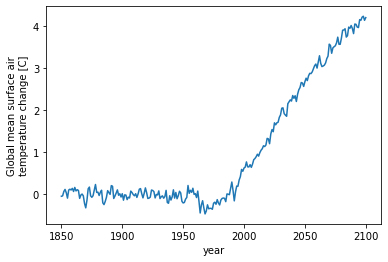

In [8]:
weights = np.cos(np.deg2rad(ds.lat))  # To account area in spherical coordinates.
gsat = (
    ds["tas"].weighted(weights).mean(("lat", "lon")).resample(time="Y").mean().compute()
)
gsat_reference = gsat.sel(time=slice("1850", "1900")).mean("time")
gsat_change = (gsat - gsat_reference).groupby("time.year").first()

gsat_change.attrs['long_name'] = 'Global mean surface air temperature change'
gsat_change.attrs['short_name'] = 'GSAT change'
gsat_change.attrs['units'] = 'C'

gsat_change.plot()

In [9]:
# Temperatures are in kelvin by default - I want them in Celsius
ds["tas"] = ds["tas"] + absolute_zero
ds["tasmax"] = ds["tasmax"] + absolute_zero

In [10]:
# Reduce scope of climate data for speed.
# Based on the geographic limits of the RiceAtlas data we have selected.
min_lon, min_lat, max_lon, max_lat = ra.total_bounds
stepsize_lat = ds.lat.values[1] - ds.lat.values[0]
stepsize_lon = ds.lon.values[1] - ds.lon.values[0]

ds = ds.where(
    (ds.lat >= min_lat - stepsize_lat)
    & (ds.lat <= max_lat + stepsize_lat)
    & (ds.lon >= min_lon - stepsize_lon)
    & (ds.lon <= max_lon + stepsize_lon),
    drop=True,
)
ds

<xarray.Dataset>
Dimensions:    (bnds: 2, lat: 54, lon: 70, time: 3012)
Coordinates:
  * time       (time) object 1850-01-16 00:00:00 ... 2100-12-16 00:00:00
  * lat        (lat) float64 -11.88 -10.62 -9.375 -8.125 ... 51.88 53.12 54.38
  * lon        (lon) float64 25.31 27.19 29.06 30.94 ... 149.1 150.9 152.8 154.7
Dimensions without coordinates: bnds
Data variables:
    time_bnds  (time, bnds, lat, lon) object dask.array<chunksize=(1200, 2, 54, 70), meta=np.ndarray>
    lat_bnds   (time, lat, bnds, lon) float64 dask.array<chunksize=(1200, 54, 2, 70), meta=np.ndarray>
    lon_bnds   (time, lon, bnds, lat) float64 dask.array<chunksize=(1200, 70, 2, 54), meta=np.ndarray>
    huss       (time, lat, lon) float32 dask.array<chunksize=(1200, 54, 70), meta=np.ndarray>
    ps         (time, lat, lon) float32 dask.array<chunksize=(1200, 54, 70), meta=np.ndarray>
    tas        (time, lat, lon) float32 dask.array<chunksize=(1200, 54, 70), meta=np.ndarray>
    tasmax     (time, lat, lon) float32 dask.array<chunksize=(1200, 54, 70), meta=np.ndarray>
Attributes:
    Conventions:                     CF-1.7 CMIP-6.2
    activity_id:                     CMIP
    branch_method:                   standard
    branch_time_in_child:            0.0
    branch_time_in_parent:           144000.0
    creation_date:                   2019-04-05T16:02:56Z
    cv_version:                      6.2.20.1
    data_specs_version:              01.00.29
    experiment:                      all-forcing simulation of the recent past
    experiment_id:                   historical
    external_variables:              areacella
    forcing_index:                   2
    frequency:                       mon
    further_info_url:                https://furtherinfo.es-doc.org/CMIP6.MOH...
    grid:                            Native N96 grid; 192 x 144 longitude/lat...
    grid_label:                      gn
    history:                         2019-04-05T15:50:03Z ; CMOR rewrote data...
    initialization_index:            1
    institution:                     Met Office Hadley Centre, Fitzroy Road, ...
    institution_id:                  MOHC
    mip_era:                         CMIP6
    mo_runid:                        u-bc179
    nominal_resolution:              250 km
    parent_activity_id:              CMIP
    parent_experiment_id:            piControl
    parent_mip_era:                  CMIP6
    parent_source_id:                UKESM1-0-LL
    parent_time_units:               days since 1850-01-01-00-00-00
    parent_variant_label:            r1i1p1f2
    physics_index:                   1
    product:                         model-output
    realization_index:               1
    realm:                           atmos
    source:                          UKESM1.0-LL (2018): \naerosol: UKCA-GLOM...
    source_id:                       UKESM1-0-LL
    source_type:                     AOGCM AER BGC CHEM
    sub_experiment:                  none
    sub_experiment_id:               none
    table_id:                        Amon
    table_info:                      Creation Date:(13 December 2018) MD5:2b1...
    title:                           UKESM1-0-LL output prepared for CMIP6
    variable_id:                     tas
    variant_label:                   r1i1p1f2
    license:                         CMIP6 model data produced by the Met Off...
    cmor_version:                    3.4.0
    tracking_id:                     hdl:21.14100/255d149c-12fc-41f1-878d-034...
    DODS_EXTRA.Unlimited_Dimension:  time

In [11]:
# Add in date auxillaries
# This is because direct access via cftime dummy is slow.
ds["dayofyear"] = ds.time.dt.dayofyear
# If the calendar is only 360 days long (a common assumption in climate
# models), then apply a correction to make it more like the 365 day
# calendar.  This is not the most accurate method of correction, but it
# is fast and easy to understand.
if ds.dayofyear.max() == 360:
    for day in (73, 145, 218, 291, 364):
        ds["dayofyear"][ds.dayofyear >= day] = ds.dayofyear[ds.dayofyear >= day] + 1

## Heat stress index

Many studies focussed on the risk of occupational heat stress use
wet-bulb globe temperature (WBGT), which is a heat-stress index
defined by ISO 7243. WBGT is intended to combine all the factors that
affect the human experience of heat, namely air temperature, radiant
temperature, humidity, and air velocity. As performing work
generates heat, in a high WBGT environment labour must be reduced in
order to maintain a safe body temperature.

We use the [psychrolib](https://github.com/psychrometrics/psychrolib)
software library, which implements formulae from the ASHRAE handbook, to
calculate wet bulb temperature.

We neglect irradiance by assuming that the black globe temperature is
approximated by the air temperature. This will be approximately true in the
shade.
WBGT in sunny weather will be underestimated, but we are focussed on long
term trends, and trends in irradiance are not so clear as those in air
temperature and humidity.

See references:
* [Parsons, K., 2006](https://doi.org/10.2486/indhealth.44.368)
* [Parsons, K., 2013](https://doi.org/10.2486/indhealth.2012-0165)
* [Lemke, B. & Kjellstrom, T.](https://doi.org/10.2486/indhealth.ms1352)

In [13]:
# This is a delayed computation, so will return quickly.
for WBGT, WBT, Ta in (
    ("wbgt_max", "wbt_max", "tasmax"),
    ("wbgt_mean", "wbt_mean", "tas"),
):
    # Specify WBT calculation, using psychrolib.
    ds[WBT] = xr.apply_ufunc(
        GetTWetBulbFromHumRatio,
        ds[Ta],
        ds["huss"],
        ds["ps"],
        dask="parallelized",
        output_dtypes=[float],
    )

    # Calculate WBGT, assuming the black globe temperature is approximated by the
    # air temperature. This will be approximately true in the shade.
    ds[WBGT] = ds[WBT] * 0.7 + ds[Ta] * 0.3
ds["wbgt_mid"] = (ds["wbgt_max"] + ds["wbgt_mean"]) / 2
ds

<xarray.Dataset>
Dimensions:    (bnds: 2, lat: 54, lon: 70, time: 3012)
Coordinates:
  * time       (time) object 1850-01-16 00:00:00 ... 2100-12-16 00:00:00
  * lat        (lat) float64 -11.88 -10.62 -9.375 -8.125 ... 51.88 53.12 54.38
  * lon        (lon) float64 25.31 27.19 29.06 30.94 ... 149.1 150.9 152.8 154.7
Dimensions without coordinates: bnds
Data variables:
    time_bnds  (time, bnds, lat, lon) object dask.array<chunksize=(1200, 2, 54, 70), meta=np.ndarray>
    lat_bnds   (time, lat, bnds, lon) float64 dask.array<chunksize=(1200, 54, 2, 70), meta=np.ndarray>
    lon_bnds   (time, lon, bnds, lat) float64 dask.array<chunksize=(1200, 70, 2, 54), meta=np.ndarray>
    huss       (time, lat, lon) float32 dask.array<chunksize=(1200, 54, 70), meta=np.ndarray>
    ps         (time, lat, lon) float32 dask.array<chunksize=(1200, 54, 70), meta=np.ndarray>
    tas        (time, lat, lon) float32 dask.array<chunksize=(1200, 54, 70), meta=np.ndarray>
    tasmax     (time, lat, lon) float32 dask.array<chunksize=(1200, 54, 70), meta=np.ndarray>
    dayofyear  (time) int64 16 46 76 106 136 166 196 ... 196 226 256 286 316 346
    wbt_max    (time, lat, lon) float64 dask.array<chunksize=(1200, 54, 70), meta=np.ndarray>
    wbgt_max   (time, lat, lon) float64 dask.array<chunksize=(1200, 54, 70), meta=np.ndarray>
    wbt_mean   (time, lat, lon) float64 dask.array<chunksize=(1200, 54, 70), meta=np.ndarray>
    wbgt_mean  (time, lat, lon) float64 dask.array<chunksize=(1200, 54, 70), meta=np.ndarray>
    wbgt_mid   (time, lat, lon) float64 dask.array<chunksize=(1200, 54, 70), meta=np.ndarray>
Attributes:
    Conventions:                     CF-1.7 CMIP-6.2
    activity_id:                     CMIP
    branch_method:                   standard
    branch_time_in_child:            0.0
    branch_time_in_parent:           144000.0
    creation_date:                   2019-04-05T16:02:56Z
    cv_version:                      6.2.20.1
    data_specs_version:              01.00.29
    experiment:                      all-forcing simulation of the recent past
    experiment_id:                   historical
    external_variables:              areacella
    forcing_index:                   2
    frequency:                       mon
    further_info_url:                https://furtherinfo.es-doc.org/CMIP6.MOH...
    grid:                            Native N96 grid; 192 x 144 longitude/lat...
    grid_label:                      gn
    history:                         2019-04-05T15:50:03Z ; CMOR rewrote data...
    initialization_index:            1
    institution:                     Met Office Hadley Centre, Fitzroy Road, ...
    institution_id:                  MOHC
    mip_era:                         CMIP6
    mo_runid:                        u-bc179
    nominal_resolution:              250 km
    parent_activity_id:              CMIP
    parent_experiment_id:            piControl
    parent_mip_era:                  CMIP6
    parent_source_id:                UKESM1-0-LL
    parent_time_units:               days since 1850-01-01-00-00-00
    parent_variant_label:            r1i1p1f2
    physics_index:                   1
    product:                         model-output
    realization_index:               1
    realm:                           atmos
    source:                          UKESM1.0-LL (2018): \naerosol: UKCA-GLOM...
    source_id:                       UKESM1-0-LL
    source_type:                     AOGCM AER BGC CHEM
    sub_experiment:                  none
    sub_experiment_id:               none
    table_id:                        Amon
    table_info:                      Creation Date:(13 December 2018) MD5:2b1...
    title:                           UKESM1-0-LL output prepared for CMIP6
    variable_id:                     tas
    variant_label:                   r1i1p1f2
    license:                         CMIP6 model data produced by the Met Off...
    cmor_version:                    3.4.0
    tracking_id:            

## Labour effect

Sahu et al observed a 5% per °C WBGT decrease in the labour capacity of
labourers harvesting rice between 23-33 °C WBGT. Rate of collection was
measured in 124 workers in groups of 10-18, and WBGT was measured in-situ, at
a single location in India.
We adopt this for our labour impact metric, and assume that this is
representative of manual rice harvest labour.

[Sahu, S. et al., 2013](https://doi.org/10.2486/indhealth.2013-0006)

See also [Gosling, S. N., Zaherpour, J. & Ibarreta, D.](http://doi.org/10.2760/07911)

Other labour impact functions are included in [../src/Labour.py](../src/Labour.py), so you
could explore how the choice of labour impact function affects the results,
and even define your own.

The '4+4+4' assumption means that air temperature in the working day is
assumed to be close to the maxmimum for 4 hours, the mean for 4 hours, and
half-way between for 4 hours. This is a reasonably good approximation.
This assumption comes from
[Kjellstrom, T. et al., 2018](https://doi.org/10.1007/s00484-017-1407-0)


In [14]:
# This is a delayed computation.
for WBGT, labour in (
    ("wbgt_max", "labour_sahu_max"),
    ("wbgt_mean", "labour_sahu_mean"),
    ("wbgt_mid", "labour_sahu_mid"),
):
    ds[labour] = xr.apply_ufunc(
        labour_sahu, ds[WBGT], dask="parallelized", output_dtypes=[float]
    )
ds

<xarray.Dataset>
Dimensions:           (bnds: 2, lat: 54, lon: 70, time: 3012)
Coordinates:
  * time              (time) object 1850-01-16 00:00:00 ... 2100-12-16 00:00:00
  * lat               (lat) float64 -11.88 -10.62 -9.375 ... 51.88 53.12 54.38
  * lon               (lon) float64 25.31 27.19 29.06 ... 150.9 152.8 154.7
Dimensions without coordinates: bnds
Data variables:
    time_bnds         (time, bnds, lat, lon) object dask.array<chunksize=(1200, 2, 54, 70), meta=np.ndarray>
    lat_bnds          (time, lat, bnds, lon) float64 dask.array<chunksize=(1200, 54, 2, 70), meta=np.ndarray>
    lon_bnds          (time, lon, bnds, lat) float64 dask.array<chunksize=(1200, 70, 2, 54), meta=np.ndarray>
    huss              (time, lat, lon) float32 dask.array<chunksize=(1200, 54, 70), meta=np.ndarray>
    ps                (time, lat, lon) float32 dask.array<chunksize=(1200, 54, 70), meta=np.ndarray>
    tas               (time, lat, lon) float32 dask.array<chunksize=(1200, 54, 70), meta=np.ndarray>
    tasmax            (time, lat, lon) float32 dask.array<chunksize=(1200, 54, 70), meta=np.ndarray>
    dayofyear         (time) int64 16 46 76 106 136 166 ... 226 256 286 316 346
    wbt_max           (time, lat, lon) float64 dask.array<chunksize=(1200, 54, 70), meta=np.ndarray>
    wbgt_max          (time, lat, lon) float64 dask.array<chunksize=(1200, 54, 70), meta=np.ndarray>
    wbt_mean          (time, lat, lon) float64 dask.array<chunksize=(1200, 54, 70), meta=np.ndarray>
    wbgt_mean         (time, lat, lon) float64 dask.array<chunksize=(1200, 54, 70), meta=np.ndarray>
    wbgt_mid          (time, lat, lon) float64 dask.array<chunksize=(1200, 54, 70), meta=np.ndarray>
    labour_sahu_max   (time, lat, lon) float64 dask.array<chunksize=(1200, 54, 70), meta=np.ndarray>
    labour_sahu_mean  (time, lat, lon) float64 dask.array<chunksize=(1200, 54, 70), meta=np.ndarray>
    labour_sahu_mid   (time, lat, lon) float64 dask.array<chunksize=(1200, 54, 70), meta=np.ndarray>
Attributes:
    Conventions:                     CF-1.7 CMIP-6.2
    activity_id:                     CMIP
    branch_method:                   standard
    branch_time_in_child:            0.0
    branch_time_in_parent:           144000.0
    creation_date:                   2019-04-05T16:02:56Z
    cv_version:                      6.2.20.1
    data_specs_version:              01.00.29
    experiment:                      all-forcing simulation of the recent past
    experiment_id:                   historical
    external_variables:              areacella
    forcing_index:                   2
    frequency:                       mon
    further_info_url:                https://furtherinfo.es-doc.org/CMIP6.MOH...
    grid:                            Native N96 grid; 192 x 144 longitude/lat...
    grid_label:                      gn
    history:                         2019-04-05T15:50:03Z ; CMOR rewrote data...
    initialization_index:            1
    institution:                     Met Office Hadley Centre, Fitzroy Road, ...
    institution_id:                  MOHC
    mip_era:                         CMIP6
    mo_runid:                        u-bc179
    nominal_resolution:              250 km
    parent_activity_id:              CMIP
    parent_experiment_id:            piControl
    parent_mip_era:                  CMIP6
    parent_source_id:                UKESM1-0-LL
    parent_time_units:               days since 1850-01-01-00-00-00
    parent_variant_label:            r1i1p1f2
    physics_index:                   1
    product:                         model-output
    realization_index:               1
    realm:                           atmos
    source:                          UKESM1.0-LL (2018): \naerosol: UKCA-GLOM...
    source_id:                       UKESM1-0-LL
    source_type:                     AOGCM AER BGC CHEM
    sub_experiment:                  none
    sub_experiment_id:               none
    table_id:                        Amon


In [15]:
# Apply 4+4+4 weighting to labour effect, to approximate sub-daily variation.
ds["labour_sahu_444"] = (
    ds["labour_sahu_max"] + ds["labour_sahu_mean"] + ds["labour_sahu_mid"]
) / 3

## Combining the data

In [16]:
# Spatially subset climate gridded data according to RiceAtlas
# RiceAtlas is in WGS 84, so I think it's fine to use the lat/lon numbers directly
# Using centroid only. Very fast, but less accurate for large regions.
ra_lons = xr.DataArray(
    ra.centroid.x.values, dims="HASC", coords={"HASC": ra.HASC.values}
)
ra_lats = xr.DataArray(
    ra.centroid.y.values, dims="HASC", coords={"HASC": ra.HASC.values}
)
ds_locations = ds.interp(lon=ra_lons, lat=ra_lats, method="nearest")
ds_locations

<ipython-input-1-38680257529d>:5: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  ra.centroid.x.values, dims="HASC", coords={"HASC": ra.HASC.values}


<xarray.Dataset>
Dimensions:           (HASC: 1183, bnds: 2, time: 3012)
Coordinates:
  * time              (time) object 1850-01-16 00:00:00 ... 2100-12-16 00:00:00
    lon               (HASC) float64 114.5 90.74 89.55 ... 75.83 75.06 82.24
    lat               (HASC) float64 4.377 27.69 26.98 ... 22.91 24.79 16.72
  * HASC              (HASC) object 'BN.BE' 'BT.BU' ... 'IN.MP.NE' 'IN.PY.YA'
Dimensions without coordinates: bnds
Data variables:
    lat_bnds          (time, HASC, bnds) float64 dask.array<chunksize=(1200, 1183, 2), meta=np.ndarray>
    lon_bnds          (time, HASC, bnds) float64 dask.array<chunksize=(1200, 1183, 2), meta=np.ndarray>
    huss              (time, HASC) float32 dask.array<chunksize=(1200, 1183), meta=np.ndarray>
    ps                (time, HASC) float32 dask.array<chunksize=(1200, 1183), meta=np.ndarray>
    tas               (time, HASC) float32 dask.array<chunksize=(1200, 1183), meta=np.ndarray>
    tasmax            (time, HASC) float32 dask.array<chunksize=(1200, 1183), meta=np.ndarray>
    dayofyear         (time) int64 16 46 76 106 136 166 ... 226 256 286 316 346
    wbt_max           (time, HASC) float64 dask.array<chunksize=(1200, 1183), meta=np.ndarray>
    wbgt_max          (time, HASC) float64 dask.array<chunksize=(1200, 1183), meta=np.ndarray>
    wbt_mean          (time, HASC) float64 dask.array<chunksize=(1200, 1183), meta=np.ndarray>
    wbgt_mean         (time, HASC) float64 dask.array<chunksize=(1200, 1183), meta=np.ndarray>
    wbgt_mid          (time, HASC) float64 dask.array<chunksize=(1200, 1183), meta=np.ndarray>
    labour_sahu_max   (time, HASC) float64 dask.array<chunksize=(1200, 1183), meta=np.ndarray>
    labour_sahu_mean  (time, HASC) float64 dask.array<chunksize=(1200, 1183), meta=np.ndarray>
    labour_sahu_mid   (time, HASC) float64 dask.array<chunksize=(1200, 1183), meta=np.ndarray>
    labour_sahu_444   (time, HASC) float64 dask.array<chunksize=(1200, 1183), meta=np.ndarray>
Attributes:
    Conventions:                     CF-1.7 CMIP-6.2
    activity_id:                     CMIP
    branch_method:                   standard
    branch_time_in_child:            0.0
    branch_time_in_parent:           144000.0
    creation_date:                   2019-04-05T16:02:56Z
    cv_version:                      6.2.20.1
    data_specs_version:              01.00.29
    experiment:                      all-forcing simulation of the recent past
    experiment_id:                   historical
    external_variables:              areacella
    forcing_index:                   2
    frequency:                       mon
    further_info_url:                https://furtherinfo.es-doc.org/CMIP6.MOH...
    grid:                            Native N96 grid; 192 x 144 longitude/lat...
    grid_label:                      gn
    history:                         2019-04-05T15:50:03Z ; CMOR rewrote data...
    initialization_index:            1
    institution:                     Met Office Hadley Centre, Fitzroy Road, ...
    institution_id:                  MOHC
    mip_era:                         CMIP6
    mo_runid:                        u-bc179
    nominal_resolution:              250 km
    parent_activity_id:              CMIP
    parent_experiment_id:            piControl
    parent_mip_era:                  CMIP6
    parent_source_id:                UKESM1-0-LL
    parent_time_units:               days since 1850-01-01-00-00-00
    parent_variant_label:            r1i1p1f2
    physics_index:                   1
    product:                         model-output
    realization_index:               1
    realm:                           atmos
    source:                          UKESM1.0-LL (2018): \naerosol: UKCA-GLOM...
    source_id:                       UKESM1-0-LL
    source_type:                     AOGCM AER BGC CHEM
    sub_experiment:                  none
    sub_experiment_id:               none
    table_id:                        Amon
    table_info:            

Temporally subset, according to dayofyear.

HARV_ST1 is the start day of the first cropping season.
HARV_END1 is the end day of the first cropping season.

Create an xr.DataArray containing dates which meet the criteria for each region.
The logic for this is imported from [../src/dayofyear.py].

In [17]:
doy_mask = xr.DataArray(
    np.array(
        [
            dayofyear_checker(
                ra[f"HARV_ST{season}"].astype(int).values,
                ra[f"HARV_END{season}"].astype(int).values,
                ds_locations.dayofyear.values,
            )
            for season in (1, 2, 3)
        ]
    ),
    dims=["seasonid", "HASC", "time"],
    coords={"HASC": ra.HASC, "seasonid": [1, 2, 3], "time": ds_locations.time},
)
ds_locations_seasons = ds_locations.where(doy_mask)
ds_locations_seasons

<xarray.Dataset>
Dimensions:           (HASC: 1183, bnds: 2, seasonid: 3, time: 3012)
Coordinates:
  * time              (time) object 1850-01-16 00:00:00 ... 2100-12-16 00:00:00
    lon               (HASC) float64 114.5 90.74 89.55 ... 75.83 75.06 82.24
    lat               (HASC) float64 4.377 27.69 26.98 ... 22.91 24.79 16.72
  * HASC              (HASC) object 'BN.BE' 'BT.BU' ... 'IN.MP.NE' 'IN.PY.YA'
  * seasonid          (seasonid) int64 1 2 3
Dimensions without coordinates: bnds
Data variables:
    lat_bnds          (time, HASC, bnds, seasonid) float64 dask.array<chunksize=(1200, 1183, 2, 3), meta=np.ndarray>
    lon_bnds          (time, HASC, bnds, seasonid) float64 dask.array<chunksize=(1200, 1183, 2, 3), meta=np.ndarray>
    huss              (time, HASC, seasonid) float32 dask.array<chunksize=(1200, 1183, 3), meta=np.ndarray>
    ps                (time, HASC, seasonid) float32 dask.array<chunksize=(1200, 1183, 3), meta=np.ndarray>
    tas               (time, HASC, seasonid) float32 dask.array<chunksize=(1200, 1183, 3), meta=np.ndarray>
    tasmax            (time, HASC, seasonid) float32 dask.array<chunksize=(1200, 1183, 3), meta=np.ndarray>
    dayofyear         (time, seasonid, HASC) float64 16.0 nan nan ... nan nan
    wbt_max           (time, HASC, seasonid) float64 dask.array<chunksize=(1200, 1183, 3), meta=np.ndarray>
    wbgt_max          (time, HASC, seasonid) float64 dask.array<chunksize=(1200, 1183, 3), meta=np.ndarray>
    wbt_mean          (time, HASC, seasonid) float64 dask.array<chunksize=(1200, 1183, 3), meta=np.ndarray>
    wbgt_mean         (time, HASC, seasonid) float64 dask.array<chunksize=(1200, 1183, 3), meta=np.ndarray>
    wbgt_mid          (time, HASC, seasonid) float64 dask.array<chunksize=(1200, 1183, 3), meta=np.ndarray>
    labour_sahu_max   (time, HASC, seasonid) float64 dask.array<chunksize=(1200, 1183, 3), meta=np.ndarray>
    labour_sahu_mean  (time, HASC, seasonid) float64 dask.array<chunksize=(1200, 1183, 3), meta=np.ndarray>
    labour_sahu_mid   (time, HASC, seasonid) float64 dask.array<chunksize=(1200, 1183, 3), meta=np.ndarray>
    labour_sahu_444   (time, HASC, seasonid) float64 dask.array<chunksize=(1200, 1183, 3), meta=np.ndarray>
Attributes:
    Conventions:                     CF-1.7 CMIP-6.2
    activity_id:                     CMIP
    branch_method:                   standard
    branch_time_in_child:            0.0
    branch_time_in_parent:           144000.0
    creation_date:                   2019-04-05T16:02:56Z
    cv_version:                      6.2.20.1
    data_specs_version:              01.00.29
    experiment:                      all-forcing simulation of the recent past
    experiment_id:                   historical
    external_variables:              areacella
    forcing_index:                   2
    frequency:                       mon
    further_info_url:                https://furtherinfo.es-doc.org/CMIP6.MOH...
    grid:                            Native N96 grid; 192 x 144 longitude/lat...
    grid_label:                      gn
    history:                         2019-04-05T15:50:03Z ; CMOR rewrote data...
    initialization_index:            1
    institution:                     Met Office Hadley Centre, Fitzroy Road, ...
    institution_id:                  MOHC
    mip_era:                         CMIP6
    mo_runid:                        u-bc179
    nominal_resolution:              250 km
    parent_activity_id:              CMIP
    parent_experiment_id:            piControl
    parent_mip_era:                  CMIP6
    parent_source_id:                UKESM1-0-LL
    parent_time_units:               days since 1850-01-01-00-00-00
    parent_variant_label:            r1i1p1f2
    physics_index:                   1
    product:                         model-output
    realization_index:               1
    realm:                           atmos
    source:                          UKESM1.0-LL (2018): \naerosol: UKCA-GLOM...
    sou

Downsample to yearly mean.

Because the harvest seasons have been selected, this will give annual results
for each harvest season. That is, more than one season per year. In locations
without multiple harvest seasons, the result will be 0.

In [18]:
ds_locations_seasons_annual = ds_locations_seasons.groupby("time.year").mean()
ds_locations_seasons_annual

,Array,Chunk
Bytes,14.25 MB,56.78 kB
Shape,"(251, 1183, 2, 3)","(1, 1183, 2, 3)"
Count,1399 Tasks,251 Chunks
Type,float64,numpy.ndarray
,Array,Chunk
Bytes,14.25 MB,56.78 kB
Shape,"(251, 1183, 2, 3)","(1, 1183, 2, 3)"
Count,1399 Tasks,251 Chunks
Type,float64,numpy.ndarray
,Array,Chunk


Weight the result according to rice harvest weight.
P_S1 means the production of the first cropping season.

In [19]:
weights = xr.DataArray(
    ra[["P_S1", "P_S2", "P_S3"]].values,
    dims=["HASC", "seasonid"],
    coords={"HASC": ra.HASC.values, "seasonid": [1, 2, 3]},
)
weights

<xarray.DataArray (HASC: 1183, seasonid: 3)>
array([[1119.,    0.,    0.],
       [  94.,    0.,    0.],
       [3196.,    0.,    0.],
       ...,
       [  17.,    0.,    0.],
       [  44.,    0.,    0.],
       [ 887.,  812.,    0.]])
Coordinates:
  * HASC      (HASC) object 'BN.BE' 'BT.BU' 'BT.CK' ... 'IN.MP.NE' 'IN.PY.YA'
  * seasonid  (seasonid) int64 1 2 3

Do a weighted average summing over locations to get a single annual value for
each cropping season.

In [20]:
# This is a somewhat slow cell, as computation is triggered.
ds_weighted_annual = (
    (ds_locations_seasons.groupby("time.year").mean() * weights).sum(("HASC"))
    / weights.sum("HASC")
).compute()
ds_weighted_annual

/home/users/champs/miniconda3/envs/RiceHeat/lib/python3.8/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


<xarray.Dataset>
Dimensions:           (bnds: 2, seasonid: 3, year: 251)
Coordinates:
  * seasonid          (seasonid) int64 1 2 3
  * year              (year) int64 1850 1851 1852 1853 ... 2097 2098 2099 2100
Dimensions without coordinates: bnds
Data variables:
    lat_bnds          (year, bnds, seasonid) float64 19.5 12.97 ... 14.06 24.36
    lon_bnds          (year, bnds, seasonid) float64 85.75 86.58 ... 88.22 95.92
    huss              (year, seasonid) float64 0.01015 0.01217 ... 0.01633
    ps                (year, seasonid) float64 8.325e+04 8.623e+04 ... 9.035e+04
    tas               (year, seasonid) float64 17.95 21.58 21.41 ... 25.05 27.06
    tasmax            (year, seasonid) float64 22.56 25.58 25.44 ... 29.16 31.14
    dayofyear         (year, seasonid) float64 224.1 166.2 221.7 ... 166.2 221.7
    wbt_max           (year, seasonid) float64 16.08 18.95 19.41 ... 21.45 23.08
    wbgt_max          (year, seasonid) float64 18.03 20.94 21.22 ... 23.77 25.5
    wbt_mean          (year, seasonid) float64 14.44 17.76 18.16 ... 20.35 21.99
    wbgt_mean         (year, seasonid) float64 15.49 18.9 19.14 ... 21.76 23.51
    wbgt_mid          (year, seasonid) float64 16.76 19.92 20.18 ... 22.76 24.5
    labour_sahu_max   (year, seasonid) float64 4.866 9.806 8.55 ... 19.85 24.35
    labour_sahu_mean  (year, seasonid) float64 2.284 3.676 5.447 ... 11.76 16.79
    labour_sahu_mid   (year, seasonid) float64 3.438 6.318 6.804 ... 15.42 20.47
    labour_sahu_444   (year, seasonid) float64 3.529 6.6 6.934 ... 15.68 20.54

Text(0, 0.5, 'Labour impact (%)')

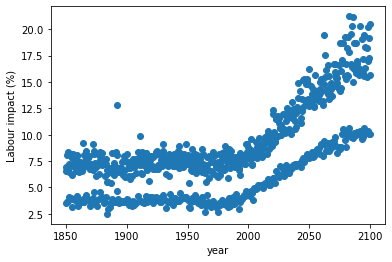

In [21]:
# Plot the labour effect against year.
ds_weighted_annual.plot.scatter("year", "labour_sahu_444")
plt.ylabel("Labour impact (%)")

There is clearly a long term trend. The data fall into two groups, as we haven't averaged over cropping seasons.

Let's examine the long term trends in the labour effect.

In [22]:
# This is a somewhat slow cell, as computation is triggered.
trend_window = 20  # how many years to average over to specify 'long-term'


def year_ranges_masking(data: xr.Dataset, trend_window: int) -> xr.Dataset:
    """Select data in a certain year range."""
    year_min = data.year.min().item()
    year_max = data.year.max().item()
    period_starts = np.array(list(range(year_min, year_max, trend_window)))
    period_middles = period_starts + trend_window / 2
    mask = xr.DataArray(
        [(data.year >= year) & (data.year > year + 20) for year in period_starts],
        dims=("period", "year",),
        coords={"year": data.year, "period": period_middles},
    )
    return data.where(mask)


ds_locations_seasons_periods = (
    year_ranges_masking(ds_locations_seasons_annual, trend_window)
    .mean("year")
    .compute()
)
ds_locations_seasons_periods

/home/users/champs/miniconda3/envs/RiceHeat/lib/python3.8/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


<xarray.Dataset>
Dimensions:           (HASC: 1183, bnds: 2, period: 13, seasonid: 3)
Coordinates:
    lon               (HASC) float64 114.5 90.74 89.55 ... 75.83 75.06 82.24
    lat               (HASC) float64 4.377 27.69 26.98 ... 22.91 24.79 16.72
  * HASC              (HASC) object 'BN.BE' 'BT.BU' ... 'IN.MP.NE' 'IN.PY.YA'
  * seasonid          (seasonid) int64 1 2 3
  * period            (period) float64 1.86e+03 1.88e+03 ... 2.08e+03 2.1e+03
Dimensions without coordinates: bnds
Data variables:
    lat_bnds          (HASC, bnds, seasonid, period) float64 3.75 3.75 ... nan
    lon_bnds          (HASC, bnds, seasonid, period) float64 114.4 114.4 ... nan
    huss              (HASC, seasonid, period) float32 0.018770438 ... nan
    ps                (HASC, seasonid, period) float32 97025.8 97029.836 ... nan
    tas               (HASC, seasonid, period) float32 25.75008 ... nan
    tasmax            (HASC, seasonid, period) float32 28.307346 ... nan
    dayofyear         (seasonid, HASC, period) float64 16.0 16.0 ... nan nan
    wbt_max           (HASC, seasonid, period) float64 24.49 24.57 ... nan nan
    wbgt_max          (HASC, seasonid, period) float64 25.64 25.72 ... nan nan
    wbt_mean          (HASC, seasonid, period) float64 23.83 23.92 ... nan nan
    wbgt_mean         (HASC, seasonid, period) float64 24.41 24.5 ... nan nan
    wbgt_mid          (HASC, seasonid, period) float64 25.02 25.11 ... nan nan
    labour_sahu_max   (HASC, seasonid, period) float64 13.77 14.2 ... nan nan
    labour_sahu_mean  (HASC, seasonid, period) float64 7.5 7.962 ... nan nan
    labour_sahu_mid   (HASC, seasonid, period) float64 10.62 11.07 ... nan nan
    labour_sahu_444   (HASC, seasonid, period) float64 10.63 11.08 ... nan nan

Draw the time series of a couple of locations
I didn't choose the locations systematically, this is just for illustration.
We should see that some locations have a clear trend, and others don't.

(0.0, 23.348042749672736)

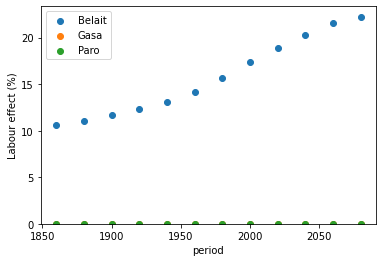

In [23]:
for HASC, data in (
    ds_locations_seasons_periods.sel(seasonid=1).isel(HASC=[0, 5, 10]).groupby("HASC")
):
    data.plot.scatter(
        "period", "labour_sahu_444", label=ra.set_index("HASC").loc[HASC].SUB_REGION
    )
plt.legend(loc="best")
plt.ylabel("Labour effect (%)")
plt.ylim(bottom=0)

Is the long-term trend dominated by global changes in surface air temperature?
If so, we would expect there to be a correlation, so let's plot the local
changes against global warming, in long-term averages.

LinregressResult(slope=3.8864191037335183, intercept=6.4758288875468875, rvalue=0.9997311714610526, pvalue=1.1051795149491577e-17, stderr=0.028502955365834193)


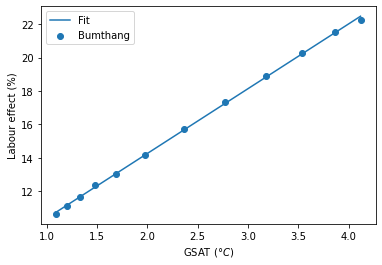

In [25]:
x = year_ranges_masking(gsat_change, trend_window).mean("year").dropna("period")
y = (
    ds_locations_seasons_periods.sel(seasonid=1)
    .isel(HASC=0)["labour_sahu_444"]
    .dropna("period")
)
plt.scatter(x, y, label=ra.iloc[1].SUB_REGION)
lr = stats.linregress(x, y)
plt.plot(x.values, x.values * lr.slope + lr.intercept, label="Fit")
plt.xlabel("GSAT ($\degree C$)")
plt.ylabel("Labour effect (%)")
plt.legend(loc="best")
print(lr)

There is a clear correlation (at least in the cropping season-location that I
selected for this example!).

Does this explain all of the year-to-year variation? No, and we wouldn't expect it to.
When we plot annual values instead of long-term averages. (This is at a single location again.)

/home/users/champs/miniconda3/envs/RiceHeat/lib/python3.8/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/users/champs/miniconda3/envs/RiceHeat/lib/python3.8/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/users/champs/miniconda3/envs/RiceHeat/lib/python3.8/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/users/champs/miniconda3/envs/RiceHeat/lib/python3.8/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/users/champs/miniconda3/envs/RiceHeat/lib/python3.8/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/users/champs/miniconda3/envs/RiceHeat/lib/python3

LinregressResult(slope=0.2359808980893987, intercept=-1.4062327635126708, rvalue=0.9694862367046956, pvalue=4.824120779992749e-154, stderr=0.003781463298430997)


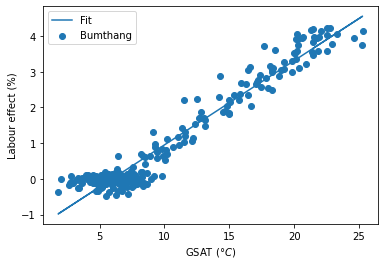

In [26]:
# This is a somewhat slow cell, as computation is triggered.
x = ds_locations_seasons_annual.sel(seasonid=1).isel(HASC=0)["labour_sahu_444"]
y = gsat_change
plt.scatter(x, y, label=ra.iloc[1].SUB_REGION)
lr = stats.linregress(x, y)
plt.plot(x, x * lr.slope + lr.intercept, label="Fit")
plt.xlabel("GSAT ($\degree C$)")
plt.ylabel("Labour effect (%)")
plt.legend(loc="best")
print(lr)

The trend is not just present in a few individual locations.
If we sum the effect across the whole region, weighting by rice production, we see a clear trend.

Text(0, 0.5, 'Labour impact %')

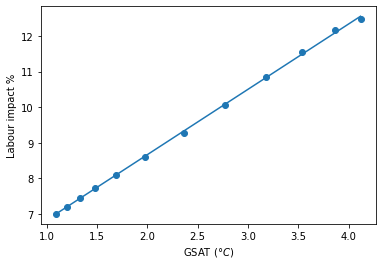

In [27]:
x = year_ranges_masking(gsat_change, trend_window).mean("year").dropna("period")
y = ds_locations_seasons_periods["labour_sahu_444"].sel(period=x.period)
y_weighted = (y * weights).sum(("seasonid", "HASC")) / weights.sum()
lr = stats.linregress(x, y_weighted)
plt.scatter(x, y_weighted)
plt.plot(x, x * lr.slope + lr.intercept)
plt.xlabel("GSAT ($\degree C$)")
plt.ylabel("Labour impact %")

The trend isn't present in all cropping location-seasons.
So, let's independently fit lines in each location-season, and see where the
trend with respect to global warming is significant.

In [28]:
def fit_parallel(X: np.ndarray, Y: np.ndarray) -> np.ndarray:
    """Do a linear fit along the last axis."""
    A = np.apply_along_axis(lambda y: stats.linregress(X, y), -1, Y,)
    return A


def fit_parallel_wrapper(
    x: xr.DataArray, y: xr.DataArray, dim: str = "time"
) -> xr.DataArray:
    """Do a linear fit along an axis, independently in other dimensions.

    Different outputs of the fit are arranged along a new dimension, to get
    around the limitation that xr.apply_ufunc can only take a single variable
    output.
    """
    result = xr.apply_ufunc(
        fit_parallel,
        x,
        y,
        input_core_dims=[[dim], [dim]],
        output_core_dims=[["linregress"]],
        dask="forbidden",
        output_dtypes=[float],
    )
    result = result.assign_coords(
        {"linregress": ["slope", "intercept", "rvalue", "pvalue", "stderr"]}
    )
    return result


x = year_ranges_masking(gsat_change, trend_window).mean("year").dropna("period")
y = ds_locations_seasons_periods["labour_sahu_444"].sel(period=x.period)
ds_parallel_fit = fit_parallel_wrapper(x.load(), y.load(), "period")
ds_parallel_fit

<xarray.DataArray (HASC: 1183, seasonid: 3, linregress: 5)>
array([[[ 3.88641910e+00,  6.47582889e+00,  9.99731171e-01,
          1.10517951e-17,  2.85029554e-02],
        [            nan,             nan,             nan,
                     nan,             nan],
        [            nan,             nan,             nan,
                     nan,             nan]],

       [[ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
          1.00000000e+00,  0.00000000e+00],
        [            nan,             nan,             nan,
                     nan,             nan],
        [            nan,             nan,             nan,
                     nan,             nan]],

       [[ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
          1.00000000e+00,  0.00000000e+00],
        [            nan,             nan,             nan,
                     nan,             nan],
        [            nan,             nan,             nan,
                     nan,             nan]],
...
       [[ 3.47001902e-01, -1.33162780e-01,  9.88917409e-01,
          1.29246345e-09,  1.64740682e-02],
        [            nan,             nan,             nan,
                     nan,             nan],
        [            nan,             nan,             nan,
                     nan,             nan]],

       [[ 2.73168500e-01, -1.43601971e-01,  9.76019448e-01,
          5.99941659e-08,  1.92662566e-02],
        [            nan,             nan,             nan,
                     nan,             nan],
        [            nan,             nan,             nan,
                     nan,             nan]],

       [[ 3.53001633e+00,  2.42460205e+01,  9.98344422e-01,
          9.76787596e-14,  6.43141183e-02],
        [ 2.15678685e+00,  9.26346775e-01,  9.92603290e-01,
          1.72219439e-10,  8.34182830e-02],
        [            nan,             nan,             nan,
                     nan,             nan]]])
Coordinates:
    lon         (HASC) float64 114.5 90.74 89.55 90.15 ... 75.83 75.06 82.24
    lat         (HASC) float64 4.377 27.69 26.98 27.02 ... 22.91 24.79 16.72
  * HASC        (HASC) object 'BN.BE' 'BT.BU' 'BT.CK' ... 'IN.MP.NE' 'IN.PY.YA'
  * seasonid    (seasonid) int64 1 2 3
  * linregress  (linregress) <U9 'slope' 'intercept' 'rvalue' 'pvalue' 'stderr'

Text(0, 0.5, 'Harvest affected (tonnes)')

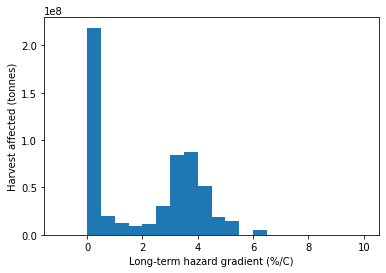

In [29]:
plt.hist(
    ds_parallel_fit.sel(linregress="slope").values.reshape(-1),
    bins=np.linspace(-1, 10, 23),
    weights=weights.values.reshape(-1),
)
plt.xlabel("Long-term hazard gradient (%/C)")
plt.ylabel("Harvest affected (tonnes)")

There is a lot of variation in this 'hazard gradient'.

Note that due to format of the data, locations which do not have multiple
cropping seasons will be present, and that empty parts of the table will have
a gradient of exactly 0.

Many of the gradients close to 0 will be non-significant, which becomes clear
when we examine the p-values of the fit:

Text(0, 0.5, 'pvalue')

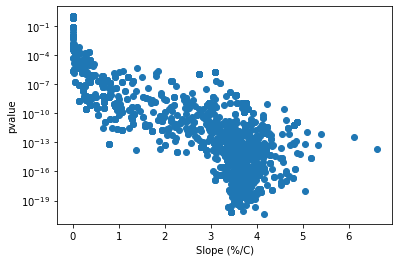

In [30]:
plt.scatter(
    ds_parallel_fit.sel(linregress="slope"), ds_parallel_fit.sel(linregress="pvalue"),
)
plt.yscale("log")
plt.xlabel("Slope (%/C)")
plt.ylabel("pvalue")

What time of year the rice is harvested is important. Harvests that occur in
November-January tend to be less affected.
Therefore, averaging over cropping seasons will sometimes obscure that
harvests in (e.g.) August are severely affected.

(Note that, because the labour affect function I've used has a lower
threshold, cropping season-locations that start off relatively cool will have
a poor goodness of fit, as the trend will have an 'elbow'.)

What is the hazard gradient in the worst affected cropping season in each
location?

/home/users/champs/miniconda3/envs/RiceHeat/lib/python3.8/site-packages/xarray/core/nputils.py:227: RuntimeWarning: All-NaN slice encountered
  result = getattr(npmodule, name)(values, axis=axis, **kwargs)


<GeoAxesSubplot:>

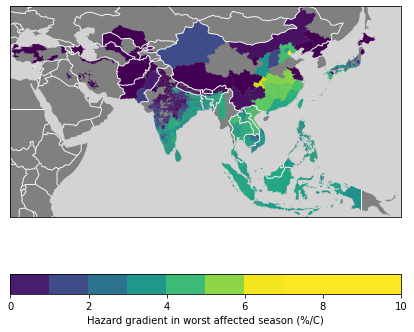

In [31]:
# Plot the gradient of the worst affected season in each location
ra["gradient_max_season"] = ds_parallel_fit.max("seasonid").sel(linregress="slope")


def map_plot(ra, variable, label, z_min, z_max, nbins):
    bins = np.round(np.linspace(z_min, z_max, nbins), 1)
    norm = mpl.colors.BoundaryNorm(boundaries=bins, ncolors=256)
    fig = plt.figure(figsize=(7, 7))
    ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree())
    min_lon, min_lat, max_lon, max_lat = ra.total_bounds
    ax.set_extent([min_lon, max_lon, min_lat, max_lat], crs=ccrs.PlateCarree())
    ax.add_feature(cfeature.LAND, facecolor="gray")
    ax.add_feature(cfeature.BORDERS, edgecolor="whitesmoke")
    ax.add_feature(cfeature.OCEAN, color="lightgray")
    return ra.plot(
        column=variable,
        legend=True,
        ax=ax,
        # norm=norm,
        legend_kwds={"label": label, "orientation": "horizontal", "boundaries": bins,},
    )


map_plot(
    ra,
    "gradient_max_season",
    "Hazard gradient in worst affected season (%/C)",
    0,
    10,
    11,
)

What proportion of the harvest in each location is exposed to a significant gradient?
Assuming this means p<0.01.


<GeoAxesSubplot:>

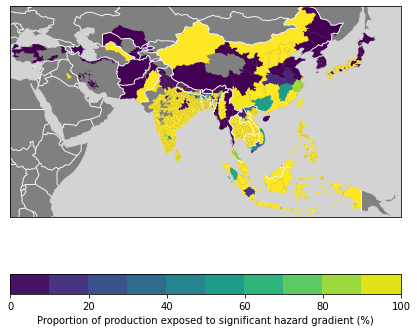

In [32]:
is_exposed = ds_parallel_fit.sel(linregress="pvalue") < 0.01
weight_exposed = weights.where(is_exposed).sum("seasonid")
ra["weight_exposed"] = weight_exposed / weights.sum("seasonid") * 100
map_plot(
    ra,
    "weight_exposed",
    "Proportion of production exposed to significant hazard gradient (%)",
    0,
    100,
    11,
)

In [33]:
# Calculate the proportion of the total harvest that is exposed.
exposed_percent = (weight_exposed.sum() / weights.sum()).item() * 100
print(f"{exposed_percent:0.1f}% of the examined harvest is exposed")

66.9% of the examined harvest is exposed


In [34]:
# In what months is production exposed?
months = [
    "Jan",
    "Feb",
    "Mar",
    "Apr",
    "May",
    "Jun",
    "Jul",
    "Aug",
    "Sep",
    "Oct",
    "Nov",
    "Dec",
]

exposed_months = np.unique(
    ra[["HMO_PK1", "HMO_PK3", "HMO_PK3"]][is_exposed.values].astype(str),
    return_counts=True,
)
exposed_months = dict(zip(exposed_months[0], exposed_months[1]))
non_exposed_months = np.unique(
    ra[["HMO_PK1", "HMO_PK3", "HMO_PK3"]][~is_exposed.values].astype(str),
    return_counts=True,
)
non_exposed_months = dict(zip(non_exposed_months[0], non_exposed_months[1]))


print("Month\tExposed\tNon-exposed\t(number of cropping season-locations)")
for month in months:
    print(month, "\t", exposed_months[month], "\t", non_exposed_months[month])

Month	Exposed	Non-exposed	(number of cropping season-locations)
Jan 	 40 	 29
Feb 	 74 	 58
Mar 	 127 	 65
Apr 	 500 	 97
May 	 137 	 43
Jun 	 239 	 73
Jul 	 141 	 27
Aug 	 426 	 60
Sep 	 425 	 481
Oct 	 223 	 371
Nov 	 553 	 581
Dec 	 322 	 200


In [35]:
# TODO
# Give project more structure - copy elements from cookiecutter project
# Add a future projection.

In [36]:
plt.show()